# Approximation of some analytical examples by using the Gaussian process
###### First written: December 6, 2019

In this notebook, I demonstrate the ability of the Gassian process to efficiently approximate some analytical examples that exhibit local features.

Firstly, I include numerical libraries as well as the Gaussian process package namely GPy.

In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

np.random.seed(0)  # Fix the seed to get the same result

%matplotlib inline

### $f(x) = \left| 0.25 - x_{1}^{2} - x_{2}^{2}\right|$
The fist analytical example that I interpolate by the Gaussian process takes the following function:

\begin{align}
    f(x) = \left| 0.25 - x_{1}^{2} - x_{2}^{2}\right|
\end{align}

Clearly the above function has a local feature, making the approximation of this function numerically challenging especially for the grid-based approximation method with the global polynomials such as Chebyshev.

Firstly we plot the above function in the domain of $[0, 1] \times [0, 1]$:

In [2]:
def f(x):
    """ The function to be predicted """
    return np.abs(0.25 - x[:, 0]**2 - x[:, 1]**2)


num_test = 1000
num_input = 2
X_test_f = np.random.uniform(0., 1., (num_test, num_input))
y_true_f = f(X_test_f)

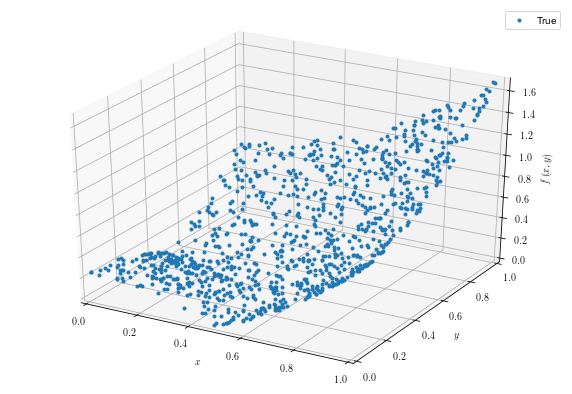

In [3]:
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_f[:, 0], X_test_f[:, 1], y_true_f.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x$")
ax.set_xlim([0., 1.])
ax.set_ylabel(r"$y$")
ax.set_ylim([0., 1.])
ax.set_zlabel(r"$f\left(x, y\right)$")
ax.set_zlim([0, None])
ax.legend(loc='best')
plt.show()

We define the mean squared error (: MSE hereafter) to measure the approximation quality: 

In [4]:
def compute_mse(y_true, y_pred):
    """ Compute the mean squared error """
    return 1 / len(y_true) * np.sum(np.square(y_true - y_pred.ravel()))

Next we instantiate and initialize the Gaussian process regression, provided by GPy, and measure MSE:

In [5]:
def return_mse(analyticFunc, X_test, Xbeg, Xend, y_true, num_trainings, num_input):
    """ Compute the mean squared error. Use the GPy library """
    mse_err = []  # Track the MSE error
    for num in num_trainings:
        # Generate training data
        X_train = np.random.uniform(Xbeg, Xend, (num, num_input))
        y_train = analyticFunc(X_train).reshape(num, 1)
        # Instantiate the Gaussian Process model
        kernel = GPy.kern.RBF(input_dim=num_input)
        gp = GPy.models.GPRegression(X_train, y_train, kernel)
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.optimize_restarts(num_restarts=10, verbose=False)
        # Make the prediction
        y_pred, sigma = gp.predict(X_test)
        # Track the error
        mse_err.append(compute_mse(y_true, y_pred))

    return mse_err

We define the number of training datasets and compute MSE with respect to the number of training examples:

In [6]:
num_trainings_f = [10, 55, 100, 550, 1000]
mse_err_f = return_mse(f, X_test_f, 0, 1, y_true_f, num_trainings_f, num_input)

Finally plot MSE of this analytical example:

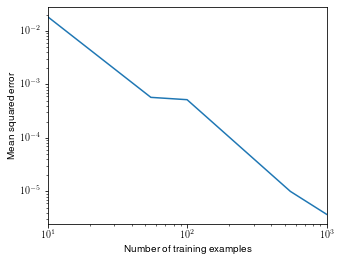

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(num_trainings_f, mse_err_f)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(num_trainings_f), np.max(num_trainings_f)])
plt.show()

### $g(x) = \exp{\left(0.3 x_{1} + 0.7 x_{2}\right)}$

The next function we address is the 2-dimensional exponential function. First we plot the function on the domain of $[-1, 1] \times [-1, 1]$:

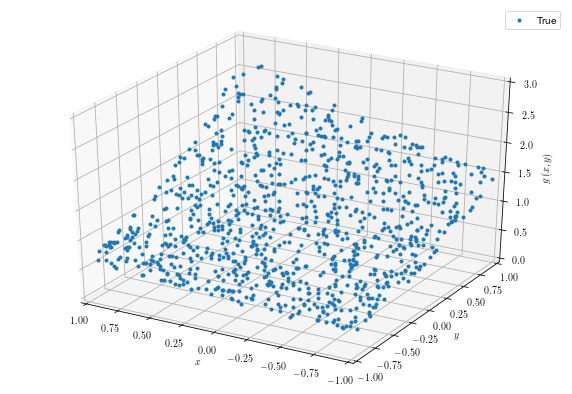

In [8]:
def g(x):
    """ The function to be predicted """
    return np.exp(0.3 * x[:, 0] + 0.7 * x[:, 1])


X_test_g = np.random.uniform([-1, -1], [1, 1], (num_test, num_input))
y_true_g = g(X_test_g)

# Plot
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_g[:, 0], X_test_g[:, 1], y_true_g.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x$")
ax.set_xlim([-1., 1.])
ax.set_ylabel(r"$y$")
ax.set_ylim([-1., 1.])
ax.invert_yaxis()
ax.set_zlabel(r"$g\left(x, y\right)$")
ax.set_zlim([0., 3.])
ax.legend(loc='best')
plt.show()

Then we check the sensitivity of MSE with respect to the number of training examples:

In [9]:
num_trainings_g = [4, 8, 16, 32, 64]
mse_err_g = return_mse(
    g, X_test_g, -1, 1, y_true_g, num_trainings_g, num_input)

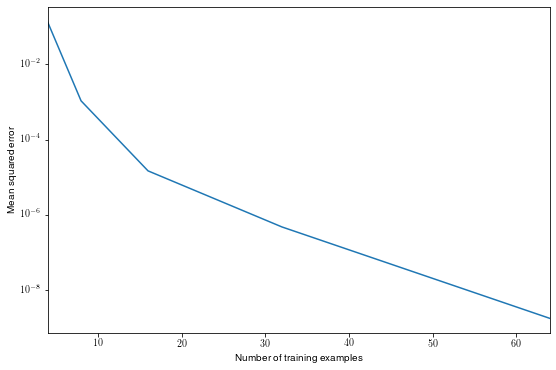

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(num_trainings_g, mse_err_g)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.set_xlim([np.min(num_trainings_g), np.max(num_trainings_g)])
plt.show()

### $h(x) = \frac{1}{\left|0.5 - x_{1}^{4} - x_{2}^{4}\right| + 0.1}$

The last example we examine in this notebook again exhibits a local feature:

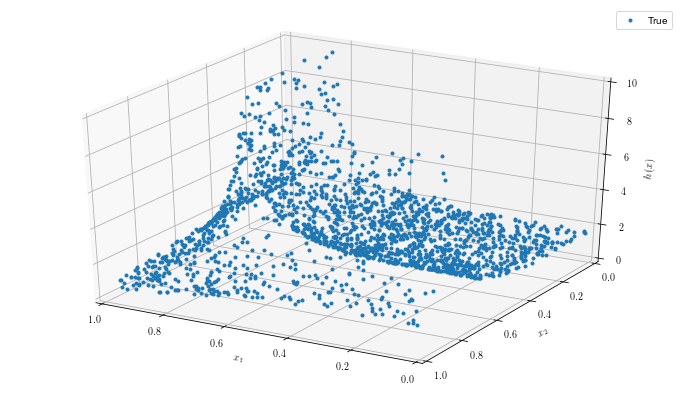

In [11]:
def h(x):
    """ The function to be predicted """
    return 1 / (np.abs(0.5 -  x[:, 0]**4 - x[:, 1]**4) + 0.1)


X_test_h = np.random.uniform([0, 0], [1, 1], (2000, num_input))
y_true_h = h(X_test_h)

# Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': '3d'})
ax.plot(X_test_h[:, 0], X_test_h[:, 1], y_true_h.ravel(), 'o', markersize=3,
        label=r'True')
ax.set_xlabel(r"$x_{1}$")
ax.set_xlim([1., 0.])
ax.set_ylabel(r"$x_{2}$")
ax.set_ylim([1., 0.])
ax.set_zlabel(r"$h\left(x\right)$")
ax.set_zlim([0., 10])
ax.legend(loc='best')
plt.show()

Then check MSE when we change the number of training examples:

In [12]:
X_test_hh = np.random.uniform([0, 0], [1, 1], (num_test, num_input))
y_true_hh = h(X_test_hh)
num_trainings_h = [10, 55, 100, 550, 1000]
mse_err_h = return_mse(
    h, X_test_hh, 0, 1, y_true_hh, num_trainings_h, num_input)

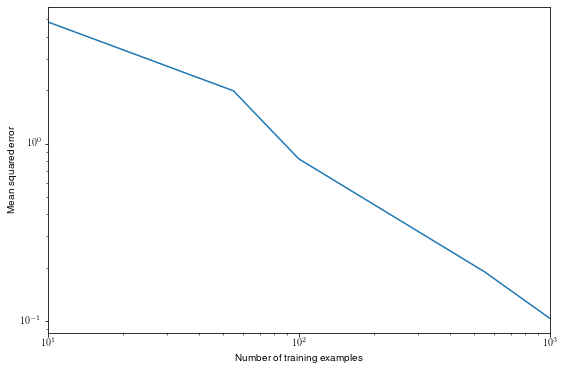

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(num_trainings_h, mse_err_h)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Mean squared error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(num_trainings_h), np.max(num_trainings_h)])
plt.show()

Unfortunately, the approximation quality is poor. We need to come up with, for instance, different kernels or the set of kernels to achieve better-fit. 